In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('.')
import hw2
from default_taq_read import readers
from nd_convert import hdf5_to_ndarray, ndarray_to_pd
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import qgrid

In [2]:
impactdata = {table: hdf5_to_ndarray('/run/media/krey/Rum/TAQ/impactdata.hdf5', table) for table in hw2.dateticker_functions.keys()}

In [3]:
import numpy as np

dates = list(readers['trade'].dates())
# perform preliminary filtering on the stocks
valid = hw2.stored['hw2_validity'].get()
tickers_0 = list(valid.columns[valid.all()])
tickers_1 = np.array(tickers_0)[~np.stack([hw2.isnan_2D(table).any(axis=0) for table, _ in impactdata.values()]).any(axis=0)]
corrupted_tickers = ['ZXZZ', 'ZVZZ']
tickers = [ticker for ticker in tickers_1 if not ticker in corrupted_tickers]
removed = set(hw2.stored['mostliquid'].get()) - set(tickers)

In [4]:
def f(xsigma, eta, beta):
    x, sigma = xsigma
    return sigma*eta*np.sign(x)*np.power(np.abs(x), beta)

total_daily_value = (ndarray_to_pd(*impactdata['vwap']) * ndarray_to_pd(*impactdata['total_daily_volume']))[tickers]
V = hw2.lookback_mean(total_daily_value, 10)
returns = ndarray_to_pd(*impactdata['returns_2min'], row_axes=[0,2])[tickers]
sigma = average_daily_vol = hw2.lookback_volatility(returns, 10)
X = ndarray_to_pd(*impactdata['imbalance'])[tickers]
S_0 = ndarray_to_pd(*impactdata['arrival_price'])[tickers]
S_tilde = ndarray_to_pd(*impactdata['vwap_at_330'])[tickers]
S_post = ndarray_to_pd(*impactdata['terminal_price'])[tickers]
T = 6/6.5
I = S_post/S_0 - 1
J = S_tilde/S_0 - 1
regression_df = pd.concat({'x': (X/(V*T)), 'sigma': sigma, 'y': (J - I/2)}, axis=1).dropna()

In [5]:
def regression(regression_tickers):
    data = regression_df.loc[:, (slice(None), regression_tickers)].stack(level=1)
    xsigma = data[['x', 'sigma']].T.values
    params, stderror = curve_fit(f, xsigma, data['y'])
    residuals = data['y'] - f(xsigma, *params)
    return {'params': params,
            'stderror': stderror,
            'residuals': residuals}

In [6]:
regression(tickers)

{'params': array([ 0.19215608,  0.74611058]),
 'residuals': 20070705  SPY    -0.001421
           QQQQ   -0.001822
           IWM    -0.002801
           JAVA    0.000037
           HD     -0.000522
           INTC   -0.000360
           CSCO   -0.002475
           GE     -0.001371
           PFE     0.003261
           F      -0.010648
           TWX    -0.005944
           MSFT   -0.000863
           ORCL   -0.003601
           EMC    -0.001865
           YHOO    0.001823
           MU     -0.002522
           AAPL    0.000693
           AMD    -0.003666
           XLE    -0.004798
           MOT    -0.000563
           AMAT   -0.006321
           XOM    -0.003078
           QID     0.002333
           QCOM   -0.001496
           XLF    -0.000862
           LVLT    0.002405
           TGT     0.003862
           HAL    -0.015601
           CNXT   -0.000341
           TSM    -0.002185
                     ...   
 20070920  ABFS   -0.019863
           LPL     0.009416
           VCI   

In [23]:
most_liquid, less_liquid = tickers[:len(tickers)//2], tickers[len(tickers)//2:]

In [24]:
regression(less_liquid)

(array([ 0.18115394,  0.72238719]),
 array([[  6.29197527e-05,   7.23927886e-05],
        [  7.23927886e-05,   7.46953689e-04]]))

In [25]:
regression(most_liquid)

(array([ 0.2335326,  0.845229 ]), array([[ 0.00011001,  0.00012571],
        [ 0.00012571,  0.00083136]]))

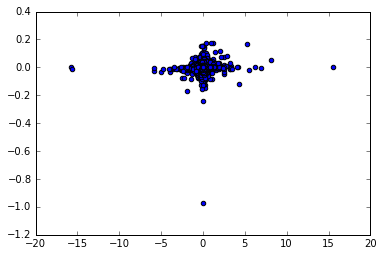

In [282]:
#plt.scatter(data['x'], data['y'])

In [115]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [89]:
true_eta = 0.9
true_beta = 0.55
samples = 10000

xs = np.random.random(samples)*2-1
noise = np.random.normal(size=samples)
ys = np.vectorize(lambda x: f(x, true_eta, true_beta))(xs) + noise
ys


array([ 3.39682287,  0.42349077, -0.96323754, ...,  1.43707159,
        1.21876062, -0.51102432])

In [90]:
curve_fit(f, xs, ys)

(array([ 0.90889967,  0.5863432 ]), array([[ 0.0004259 ,  0.0005042 ],
        [ 0.0005042 ,  0.00120613]]))